In [2]:
'''
Author: daniel
Date: 2023-03-04 09:30:14
LastEditTime: 2023-03-13 22:28:45
LastEditors: daniel
Description: 
FilePath: /Cerberus-main/jupyters/draw_bsds_rind_qualitative_results.ipynb
have a nice day
'''


from PIL import Image

import os
from os.path import split,join, isdir ,exists
os.chdir('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main')
from loguru import logger
import torch
import numpy as np
import skimage
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
from PIL import Image

from utils import *
plt.rcParams['savefig.dpi'] = 300 #图片像素
plt.rcParams['figure.dpi'] = 300 #分辨率


from utils.entity.bsds_rind_gt_loader import * 
from utils.entity.bsds_rind_qualitative_drawer import * 

# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)


In [3]:


def get_best_image(main_drawer,other_drawer_list,task = 'reflectance'):

    n =  len(other_drawer_list)

    distance_dict = {}
    
    for index in range(main_drawer.__len__()):

        main_f, name  = main_drawer.get_task_F_quantitatives(task,index)
        distance = 0 


        for d in other_drawer_list:
            distance += (main_f - d.get_task_F_quantitatives(task,index)[0])

        
        distance_dict[name] = distance/n

    
    return  sorted(distance_dict.items(), key =lambda k : k[1])[::-1]
    

RINDNET_ROOT="/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/trash/precomputed"

our_drawer = QualitativeDrawer('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/full_version_0','ours')



rindnet_drawer = QualitativeDrawer(join(RINDNET_ROOT,"rindnet-resnet50"),'rindnet')
dff_drawer = QualitativeDrawer(join(RINDNET_ROOT,"dff"),'dff')
rcf_drawer = QualitativeDrawer(join(RINDNET_ROOT,"rcf"),'rcf')
hed_drawer = QualitativeDrawer(join(RINDNET_ROOT,"hed"),'hed')

# our_drawer.get_quantitatives(0)


In [6]:
compare_results = get_best_image(our_drawer,[rindnet_drawer,dff_drawer,rcf_drawer,hed_drawer],'reflectance')
compare_results[:10]

[('176051', 0.44332475000000005),
 ('296028', 0.36201125),
 ('238025', 0.3376892499999999),
 ('384022', 0.33338025000000004),
 ('65084', 0.32604550000000004),
 ('77062', 0.31513135000000003),
 ('141048', 0.3112675),
 ('187058', 0.30599425),
 ('164046', 0.30295422499999997),
 ('100039', 0.29616750000000003)]

176051
296028
238025
384022
65084
77062
141048
187058
164046
100039
376086
160006
388006
134049
2018
235098
268074
346016
70011
189029
51084
141012
103006
253092
106005
385022
120003
3063
225022
179084
257098
289011
147080
92014
306051
230098
181021
223004
102062
108069
49024
48025
209021
388018
14092
61034
15011
35028
217013
159002
35028
145079
103078
207038
5096
65084
10081
344010
247003
140006
41006
253016
102062
81095
209021
134067
106047
306051
2018
226022
78098
16068
226033
134049
14085
97010
208078
176051
302022
258089
267036
108004
220003
43051
296028
247012
104055
384089
80090
385022
296058
104010
29030
147077
235098
107072
159002
108036
120003
290035
134067
163004
257098
306052
202000
130066
51084
100007
65084
41006
247012
196027
217013
179084
100099
112056
206062
103029
365072
376086
101027
220003
267036
49024
107072
23050
187058
246009
71076
102062
290035
277053
160067
8068
43033
226060
344010
288024
226043
196040
347031
388018
223004
41029
189029
106047
64061
168084
108036

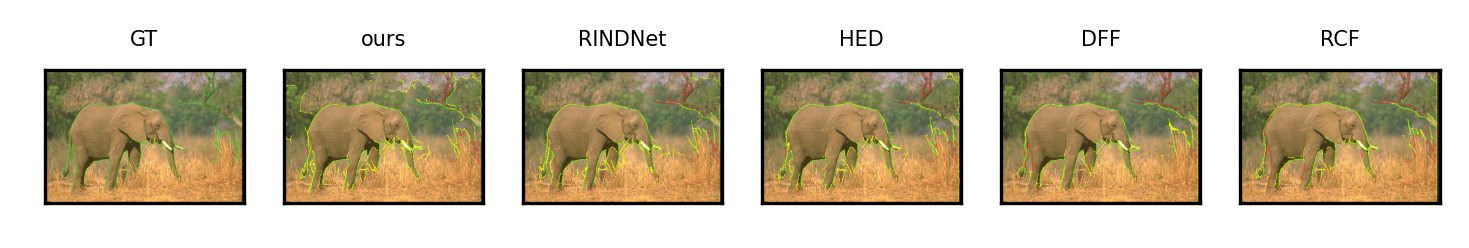

In [4]:
# demo_task = 'reflectance'

best_list = {}

# for demo_task in ['reflectance',"illumination","normal","depth"]:
for demo_task in ['reflectance']:

    demo_threshold_range = [0.5]
    
    compare_save_dir = 'logs/bsds/compare/%s'%(demo_task)
    make_dir(compare_save_dir)
    origin_save_dir = 'logs/bsds/gt/%s'%(demo_task)
    make_dir(origin_save_dir)

    gt_loader = GtLoader()

    compare_results = get_best_image(our_drawer,[rindnet_drawer,dff_drawer,rcf_drawer,hed_drawer],demo_task)
    top10_name_list = [x[0] for x in compare_results]
    best_list[demo_task] = compare_results[:30]
    

    for name in top10_name_list[:50]:

        print(name)
        save_name = join(compare_save_dir,'%s.png'%(name))
        

        if exists(save_name):
            a = imread(save_name)[:,:,::-1]
            show_imgs([a],[0])
            continue

        #* origin image
        origin_save_name = join(origin_save_dir,'%s.png'%(name))

        if not exists(origin_save_name):
            edge = gt_loader.get_edge_by_task(demo_task,name)


            
            origin_image = gt_loader.get_image(name)[:,:,::-1]

            filter_pred_edge = dilation(edge,times=1.2)/255
            
            origin_image[edge==1]  = our_drawer.COLORS['TP']
            show_imgs([origin_image],[0],img_name=origin_save_name)
        else:
            origin_image = imread(origin_save_name)[:,:,::-1]

            
        idx = our_drawer.name2idx(name)
        image = our_drawer.draw_edge(demo_task,idx,demo_threshold_range)
        rindnet_image = rindnet_drawer.draw_edge(demo_task,idx,demo_threshold_range)
        dff_image = dff_drawer.draw_edge(demo_task,idx,demo_threshold_range)
        rcf_image = rcf_drawer.draw_edge(demo_task,idx,demo_threshold_range)
        hed_image = hed_drawer.draw_edge(demo_task,idx,demo_threshold_range)


        tmp = [origin_image] + image +  rindnet_image + hed_image + dff_image + rcf_image 

        show_imgs(tmp,[0]*len(tmp),['GT','ours', 'RINDNet', 'HED', 'DFF','RCF'],
                    img_name = save_name)

                    
        

    

## get best image according to the F-score 

In [5]:



our_drawer = QualitativeDrawer('/home/DISCOVER_summer2022/xusc/exp/Cerberus-main/networks/need2release/full_version_0','ours')





In [6]:


# best_images = get_best_image(our_drawer)[:10]
# our_drawer.getitem_by_task('reflectance',0)

gt_loader = GtLoader()

image,generic_edge,reflectance_edge,illumination_edge,normal_edge,depth_edge = gt_loader.getitem('61034')

# image = image[:,:,::-1]
# reflectance_edge = reflectance_edge[:,:,::-1]
# illumination_edge = illumination_edge[:,:,::-1]
# normal_edge = normal_edge[:,:,::-1]
# depth_edge = depth_edge[:,:,::-1]


In [7]:


self.RINDE_COLOR = [
        (10,139,226),
        (142,217,199),
        (235,191,114),
        (174, 125, 176),
        (219, 118, 2)
        ]
show_imgs([image,reflectance_edge,illumination_edge,normal_edge,depth_edge],[0]*8)

NameError: name 'self' is not defined

In [ ]:


# gt_loader = GtLoader()

# for name in [x[0] for x in get_best_image(our_drawer)][10:40]:

#     # image  = gt_loader.get_image(name)[:,:,::-1]
#     image,generic_edge,reflectance_edge,illumination_edge,normal_edge,depth_edge = gt_loader.getitem(name)

#     atten_reflectance,atten_illumination,atten_normal,atten_depth = our_drawer.get_attention(name)

#     print(our_drawer.get_F_quantitatives(our_drawer.name2idx(name)))
#     #* RIND ---> DIRN
#     show_imgs([image[:,:,::-1],generic_edge],[0,0,0])
#     show_imgs([reflectance_edge,atten_depth],[0,0,0])
#     show_imgs([illumination_edge,atten_illumination],[0,0,0])
#     show_imgs([normal_edge,atten_reflectance],[0,0,0])
#     show_imgs([depth_edge,atten_normal],[0,0,0])
#     print("============================================================================")
    

    

